In [1]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision, torch
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
# proxy="http://sysproxy.wal-mart.com:8080"
# os.environ['http_proxy'] = proxy 
# os.environ['HTTP_PROXY'] = proxy
# os.environ['https_proxy'] = proxy
# os.environ['HTTPS_PROXY'] = proxy


# export HTTP_PROXY=http://sysproxy.wal-mart.com:8080
# export HTTPS_PROXY=http://sysproxy.wal-mart.com:8080

In [15]:
# from transformers import CLIPProcessor, CLIPModel

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# url = "/home/jupyter/dvc-manual/gtin_60/data/prep/enrollment_filtered/test-samples/19100110007/0.png"
# image = Image.open(url)
# inputs = processor(text=["a photo of a lotion", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
# outputs = model(**inputs)
# logits_per_image = outputs.logits_per_image # this is the image-text similarity score
# probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [23]:
# import json

# def imgToDataLoader(img_folder_path,size, batchsize=256):
#     # testSet= torchvision.datasets.ImageFolder(root=img_folder_path,transform=transforms.Compose([transforms.ToTensor(),]))
#     testSet= torchvision.datasets.ImageFolder(root=img_folder_path,transform=transforms.Compose([transforms.Resize(size=size),transforms.ToTensor(),]))
#     test_dataloader_args=dict(shuffle=False, batch_size=batchsize,num_workers=2, pin_memory=True)
#     test_loader= torch.utils.data.DataLoader(testSet, **test_dataloader_args)
#     return test_loader

# path= '/home/jupyter/'+'dvc-manual/gtin_60/data/prep/enrollment/subsets/enrollment_size_90_SN_1'
# enrollment_loader=imgToDataLoader(path, 128, 256)



In [6]:
# # preprocess_images = [(preprocess(Image.open(img_path)),lab) for img_path,lab in os.listdir(enrollment_path)]

In [38]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
from transformers import CLIPProcessor, CLIPModel
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = # clip.load('ViT-B/32', device)

test_path= os.path.join(os.getcwd(),'dvc-manual/gtin_60/data/prep/test')
test_preprocess= torchvision.datasets.ImageFolder(root=test_path,transform=preprocess)

import glob
preprocess_images=[]
for val in glob.glob(test_path+"/*/*"):
    img_path,label= val,val.split("/")[-2]
    preprocess_images.append((preprocess(Image.open(img_path)),label))
    
labels = [i for i in os.listdir(test_path)]
# tkns = ['A photo of '+label for label in labels]
# text = clip.tokenize(labels).to(device)
text_inputs = torch.cat([clip.tokenize(c) for c in test_preprocess.classes]).to(device)


item_dict={}
for k,v in enumerate(test_preprocess.classes):
    item_dict[k]=v

In [71]:

# preprocess_images = [(preprocess(Image.open(img_path)),lab) for img_path,lab in os.listdir(enrollment_path)]

# Prepare the inputs
# image, class_id = cifar100[3637]
# image_input = preprocess(image).unsqueeze(0).to(device)
# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

BATCH_SIZE = 100
ln = len(preprocess_images)

results = []

for i in tqdm(range(0,ln,BATCH_SIZE)):
    img_batch= preprocess_images[i:i+BATCH_SIZE]
    batch_tensor= [x[0] for x in img_batch]
    image_input = torch.tensor(np.stack(batch_tensor)).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        logits_per_image, logits_per_text = model(image_input, text_inputs)
        # # The softmax function takes the original confidence and applys a transform to make all the confidence add up to one
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        results.append(probs)

    # Pick the top 5 most similar labels for the image
    # image_features /= image_features.norm(dim=-1, keepdim=True)
    # text_features /= text_features.norm(dim=-1, keepdim=True)
    # similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    # values, indices = similarity[0].topk(1)

    # Print the result
    # print("\nTop predictions:\n")
    # for value, index in zip(values, indices):
    #     print(f"{test_preprocess.classes[index]:>16s}: {100 * value.item():.2f}%")

res = np.concatenate(results,axis=0)
choices = np.argmax(res,axis=1)
pred_label= [item_dict[i] for i in choices]
true_label= [x[1] for x in preprocess_images]


acc= metrics.accuracy_score(np.array(true_label),np.array(pred_label))
report=sklearn.metrics.classification_report(np.array(true_label),np.array(pred_label))

# correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
prec, rec,fscore,supp=precision_recall_fscore_support(np.array(true_label),np.array(pred_label), average='macro')
w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(true_label),np.array(pred_label), average='weighted')
report_dict=sklearn.metrics.classification_report(np.array(true_label),np.array(pred_label),output_dict=True)

print(acc)
print(report)

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

0.07167004732927654
              precision    recall  f1-score   support

 12000809941       0.12      0.12      0.12        43
 13000006057       0.00      0.00      0.00       110
 13130006125       0.00      0.00      0.00       141
 19100110007       0.00      0.00      0.00        45
 19200771825       0.08      0.50      0.14       119
 34000003303       0.00      0.00      0.00       121
 34500151368       0.11      0.01      0.02        99
 44000033255       0.00      0.00      0.00       119
 49000012781       0.00      0.00      0.00       103
703820010944       0.03      0.01      0.01       114
 78742012285       0.08      0.37      0.13        91
 78742228037       0.00      0.00      0.00       115
 78742351865       0.00      0.00      0.00       111
 78742370064       0.00      0.00      0.00       109
  9800800254       0.06      0.15      0.08        39

    accuracy                           0.07      1479
   macro avg       0.03      0.08      0.03      1479
weight


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import math
import yaml
import copy
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts


class CLIPWrapper(pl.LightningModule):
    def __init__(self,
                 model_name: str,
                 config: dict,
                 minibatch_size: int
                 ):
        """A lightning wrapper for a CLIP model as specified in the paper.

        Args:
            model_name (str): A case sensitive visual model name.
            config (dict): A dictionary containing the CLIP instantiation parameters.
        """
        super().__init__()

        self.model_name = model_name
        self.model = CLIP(**config)
        self.minibatch_size = minibatch_size
        self.isViT = 'ViT' in self.model_name

        self.automatic_optimization = False
    
    # Sourced from https://github.com/PyTorchLightning/pytorch-lightning/issues/5449
    @property
    def num_training_steps(self) -> int:
        """Total training steps inferred from datamodule and devices."""
        dataset = self.trainer._data_connector._train_dataloader_source.dataloader()
        if self.trainer.max_steps:
            return self.trainer.max_steps

        dataset_size = len(dataset)

        num_devices = max(1, self.trainer.num_gpus, self.trainer.num_processes)

        return (dataset_size // num_devices) * self.trainer.max_epochs

    # Training loss: https://github.com/openai/CLIP/issues/83
    # Mini-batching thanks to https://github.com/crowsonkb / https://twitter.com/RiversHaveWings
    # Multi-GPU support: https://github.com/MicPie/clasp
    def training_step(self, train_batch, idx):
        # get optimizers and scheduler
        optimizer = self.optimizers()
        
        image, text = train_batch
        n = math.ceil(len(image) // self.minibatch_size)
        image_mbs = torch.chunk(image, n)
        text_mbs = torch.chunk(text, n)

        # calculate original statistics
        with torch.no_grad():
            print("Inside torch.no_grad()")
            ims = [F.normalize(self.model.encode_image(im), dim=1) for im in image_mbs]
            txt = [F.normalize(self.model.encode_text(t), dim=1) for t in text_mbs]
            # gather from all GPUs
            ims = self.all_gather(torch.cat(ims))
            txt = self.all_gather(torch.cat(txt))

            if len(ims.shape) == 3:
                ims = list(ims)
                txt = list(txt)
            else:
                ims = [ims]
                txt = [txt]
            
            image_logits = torch.cat(ims) @ torch.cat(txt).t() * self.model.logit_scale.exp()
            ground_truth = torch.arange(len(image_logits)).type_as(image_logits).long()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth)).div(2)
            acc_i = (torch.argmax(image_logits, 1) == ground_truth).sum()
            acc_t = (torch.argmax(image_logits, 0) == ground_truth).sum()
            self.log_dict({'loss': loss / len(ims), 'acc': (acc_i + acc_t) / 2 / len(image) / len(ims)}, prog_bar=True)

        if isinstance(optimizer, list):
            optimizer = optimizer[0]
        optimizer.zero_grad()
        print("print v2")
        # image loss
        for j, mb in enumerate(image_mbs):
            images_tmp = copy.deepcopy(ims)
            images_tmp[self.global_rank][j*self.minibatch_size:(j+1)*self.minibatch_size] = F.normalize(self.model.encode_image(mb), dim=1)
            image_logits = torch.cat(images_tmp) @ torch.cat(txt).t() * self.model.logit_scale.exp()
            ground_truth = torch.arange(len(image_logits)).type_as(image_logits).long()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth))/2
            self.manual_backward(loss)
        print("print v3")
        # text loss
        for j, mb in enumerate(text_mbs):
            text_tmp = copy.deepcopy(txt)
            text_tmp[self.global_rank][j*self.minibatch_size:(j+1)*self.minibatch_size] = F.normalize(self.model.encode_text(mb), dim=1)
            image_logits = torch.cat(ims) @ torch.cat(text_tmp).t() * self.model.logit_scale.exp()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth))/2
            self.manual_backward(loss)
        print("print v4")
        optimizer.step()
        lr_scheduler = self.lr_schedulers()
        lr_scheduler.step()
        print("print v5")
        self.model.logit_scale.data.clamp_(-np.log(100), np.log(100))

    def validation_step(self, val_batch, idx):
        image, text = val_batch
        image_logits, text_logits = self.forward(image, text)
        ground_truth = torch.arange(len(image_logits))
        loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(text_logits, ground_truth)).div(2)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        lr = {
            "RN50": 5e-4,
            "RN101": 5e-4,
            "RN50x4": 5e-4,
            "RN50x16": 4e-4,
            "RN50x64": 3.6e-4,
            "ViT-B/32": 5e-4,
            "ViT-B/16": 5e-4,
            "ViT-L/14": 4e-4,
            "ViT-L/14-336px": 2e-5
        }[self.model_name]

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            betas=(
                0.9,
                0.98 if self.isViT else 0.999
            ),
            eps=1e-6 if self.isViT else 1e-8,
            weight_decay=0.2
        )

        # Source: https://github.com/openai/CLIP/issues/107
        # Use pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
        lr_scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps=self.num_training_steps,
            cycle_mult=1.0,
            max_lr=lr,
            min_lr=0,
            warmup_steps=100
        )

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}


class CustomCLIPWrapper(CLIPWrapper):
    def __init__(self,
                 image_encoder,
                 text_encoder,
                 minibatch_size,
                 learning_rate=5e-4,
                 kl_coeff=1.0,
                 avg_word_embs=False
                 ):
        with open('models/configs/RN.yaml') as fin:
            config = yaml.safe_load(fin)['RN50']
        super().__init__('RN50', config, minibatch_size)
        del self.model.visual
        del self.model.transformer
        self.model.visual = image_encoder
        self.model.transformer = text_encoder
        self.learning_rate = learning_rate
        self.avg_word_embs = avg_word_embs
        self.sink_temp = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        # init self-distillation model
        self.teacher = copy.deepcopy(self.model)
        self.kl_coeff = kl_coeff

    def training_step(self, train_batch, idx):
        # get optimizers and scheduler
        optimizer = self.optimizers()

        image, text = train_batch
        n = math.ceil(len(image) // self.minibatch_size)
        image_mbs = torch.chunk(image, n)
        text_mbs = torch.chunk(text, n)

        # adjust embedding dictionaries
        # text_mbs = []
        # for s in text_mbs_ids:
        #     d = {}
        #     for key in list(text.keys()):
        #         d[key] = text[key][s]
        #     text_mbs.append(d)

        # calculate original statistics
        with torch.no_grad():
            ims = [F.normalize(self.model.encode_image(im), dim=1) for im in image_mbs]
            txt = [F.normalize(self.encode_text(t), dim=1) for t in text_mbs]
            # gather from all GPUs
            ims = self.all_gather(torch.cat(ims))
            txt = self.all_gather(torch.cat(txt))

            if len(ims.shape) == 3:
                ims = list(ims)
                txt = list(txt)
            else:
                ims = [ims]
                txt = [txt]

            image_logits_notemp = torch.cat(ims) @ torch.cat(txt).t()
            image_logits = image_logits_notemp * self.model.logit_scale.exp()
            ground_truth = torch.arange(len(image_logits)).type_as(image_logits).long()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth)).div(2)
            acc_i = (torch.argmax(image_logits, 1) == ground_truth).sum()
            acc_t = (torch.argmax(image_logits, 0) == ground_truth).sum()
            # calculate teacher
            teacher_ims = [F.normalize(self.teacher.encode_image(im), dim=1) for im in image_mbs]
            teacher_txt = [F.normalize(self.encode_text(t, teacher=True), dim=1) for t in text_mbs]

            teacher_ims = self.all_gather(torch.cat(teacher_ims))
            teacher_txt = self.all_gather(torch.cat(teacher_txt))

            if len(teacher_ims.shape) == 3:
                teacher_ims = list(teacher_ims)
                teacher_txt = list(teacher_txt)
            else:
                teacher_ims = [teacher_ims]
                teacher_txt = [teacher_txt]

            sim_ii, sim_tt, sim_it, sim_ti = self.compute_similarities(torch.cat(teacher_ims), torch.cat(teacher_txt))

            # optimal transport
            img_cost = - (sim_ii + sim_tt + sim_it)
            txt_cost = - (sim_ii + sim_tt + sim_ti)
            img_target = self.sinkhorn(img_cost)
            txt_target = self.sinkhorn(txt_cost)
            loss += (F.kl_div(F.log_softmax(image_logits_notemp * self.sink_temp, dim=-1), img_target, reduction='batchmean') + F.kl_div(F.log_softmax(image_logits_notemp.t() * self.sink_temp, dim=-1), txt_target, reduction='batchmean')) / 2 * self.kl_coeff
            self.log_dict({'loss': loss / len(ims), 'acc': (acc_i + acc_t) / 2 / len(image) / len(ims)}, prog_bar=True)

        if isinstance(optimizer, list):
            optimizer = optimizer[0]
        optimizer.zero_grad()

        # image loss
        for j, mb in enumerate(image_mbs):
            images_tmp = copy.deepcopy(ims)
            images_tmp[self.global_rank][j*self.minibatch_size:(j+1)*self.minibatch_size] = F.normalize(self.model.encode_image(mb), dim=1)
            image_logits_notemp = torch.cat(images_tmp) @ torch.cat(txt).t()
            image_logits = image_logits_notemp * self.model.logit_scale.exp()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth))/2
            loss += (F.kl_div(F.log_softmax(image_logits_notemp * self.sink_temp, dim=-1), img_target, reduction='batchmean') + F.kl_div(F.log_softmax(image_logits_notemp.t() * self.sink_temp, dim=-1), txt_target, reduction='batchmean')) / 2 * self.kl_coeff
            self.manual_backward(loss)

        # text loss
        for j, mb in enumerate(text_mbs):
            text_tmp = copy.deepcopy(txt)
            text_tmp[self.global_rank][j*self.minibatch_size:(j+1)*self.minibatch_size] = F.normalize(self.encode_text(mb), dim=1)
            image_logits_notemp = torch.cat(ims) @ torch.cat(text_tmp).t()
            image_logits = image_logits_notemp * self.model.logit_scale.exp()
            loss = (F.cross_entropy(image_logits, ground_truth) + F.cross_entropy(image_logits.t(), ground_truth))/2
            loss += (F.kl_div(F.log_softmax(image_logits_notemp * self.sink_temp, dim=-1), img_target, reduction='batchmean') + F.kl_div(F.log_softmax(image_logits_notemp.t() * self.sink_temp, dim=-1), txt_target, reduction='batchmean')) / 2 * self.kl_coeff
            self.manual_backward(loss)

        optimizer.step()
        lr_scheduler = self.lr_schedulers()
        lr_scheduler.step()
        self.model.logit_scale.data.clamp_(-np.log(100), np.log(100))
        self.sink_temp.data.clamp_(-np.log(100), np.log(100))
        self.update_teacher()

    def encode_text(self, inputs, teacher=False):
        # we're gonna change this to model.CLIP.encode_text
        # if self.avg_word_embs:
        #     sequence_output = self.teacher.transformer(**inputs)[0] if teacher else self.model.transformer(**inputs)[0]

        #     embeddings = torch.sum(
        #         sequence_output * inputs["attention_mask"].unsqueeze(-1), dim=1
        #     ) / torch.clamp(torch.sum(inputs["attention_mask"], dim=1, keepdims=True), min=1e-9)

        #     return embeddings
        # else:
        #     return self.teacher.transformer(**inputs)[1] if teacher else self.model.transformer(**inputs)[1]

        inference = self.teacher if teacher else self.model

        x = inference.token_embedding(inputs).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + inference.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = inference.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = inference.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), inputs.argmax(dim=-1)] @ self.model.text_projection

        return x

    def compute_similarities(self, I_emb, T_emb):
        sim_ii, sim_tt = I_emb @ I_emb.t(), T_emb @ T_emb.t()
        sim_it, sim_ti = I_emb @ T_emb.t(), T_emb @ I_emb.t()
        return sim_ii, sim_tt, sim_it, sim_ti

    def update_teacher(self):
        for teacher, student in zip(self.teacher.parameters(), self.model.parameters()):
            teacher.data.copy_(self.ema(teacher.data, student.data))

    def ema(self, s, t):
        return s * (1 - 0.999) + t * 0.999

    def forward(self, images, text):
        logits = F.normalize(self.model.encode_image(images), dim=1) @ F.normalize(self.encode_text(text), dim=1).t() * self.model.logit_scale.exp()
        return logits, logits.t()

    # Sourced from: https://github.com/facebookresearch/swav/blob/5e073db0cc69dea22aa75e92bfdd75011e888f28/main_swav.py#L354
    def sinkhorn(self, out):
        Q = torch.exp(out / 0.05).t()  # Q is K-by-B for consistency with notations from our paper
        B = Q.shape[1]  # number of samples to assign
        K = Q.shape[0]  # how many prototypes

        # make the matrix sums to 1
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        for it in range(3):
            # normalize each row: total weight per prototype must be 1/K
            sum_of_rows = torch.sum(Q, dim=1, keepdim=True)
            Q /= sum_of_rows
            Q /= K

            # normalize each column: total weight per sample must be 1/B
            Q /= torch.sum(Q, dim=0, keepdim=True)
            Q /= B

        Q *= B  # the colomns must sum to 1 so that Q is an assignment
        return Q.t()

    def configure_optimizers(self):
        lr = self.learning_rate

        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=lr,
            momentum=0.9
        )
        print(self.num_training_steps)
        # Source: https://github.com/openai/CLIP/issues/107
        # Use pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
        lr_scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps= 200,#self.num_training_steps,
            cycle_mult=1.0,
            max_lr=lr,
            min_lr=0,
            warmup_steps=50
        )

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}


In [23]:
import torch
from collections import OrderedDict
from typing import Tuple, Union
import clip
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
clp, preprocess = clip.load("ViT-B/32", device=dev, jit=False)
    
if hparams.minibatch_size < 1:
    hparams.minibatch_size = hparams.batch_size

for p in clp.parameters(): 
    p.data = p.data.float() 
    if p.grad:
        p.grad.data = p.grad.data.float()

model = CustomCLIPWrapper(clp.visual, clp.transformer, hparams.minibatch_size, avg_word_embs=True)
ckpt = "/home/jupyter/train-CLIP-FT/lightning_logs/version_7/checkpoints/epoch=31-step=4063.ckpt"
new_model=CustomCLIPWrapper()
new_weights=new_model.state_dict()
old_weights= list(torch.load(ckpt)['state_dict'].items())
# model = CustomCLIPWrapper.load_from_checkpoint(ckpt)

NameError: name 'hparams' is not defined

In [2]:
import torch
from collections import OrderedDict
from typing import Tuple, Union
import clip
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

ckpt = "/home/jupyter/train-CLIP-FT-old/lightning_logs/version_7/checkpoints/epoch=31-step=4063.ckpt"
loaded_model=torch.load(ckpt)

In [4]:
loaded_model["hyper_parameters"]

KeyError: 'hyper_parameters'

## Enrollment Evaluation

In [ ]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision, torch
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
# from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)
# device

# PATH="/home/jupyter/train-CLIP-FT/lightning_logs/version_4/checkpoints/epoch=31-step=16319.ckpt"
PATH = "/home/jupyter/train-CLIP-FT/lightning_logs/version_4/checkpoints/epoch=31-step=4063.ckpt"
model = torch.load(PATH, map_location='cpu')
print("model loaded")
test_label_dict={}
enrollment_label_dict={}


    

    

    
    


metric_agg= pd.DataFrame(columns=["enrollment_batch_size","set_number","accuracy","precision","recall","fbeta_score","weighted_precision","weighted_recall","weighted_fbeta"])

def get_features(dataset, BATCH_SIZE=100):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=BATCH_SIZE)):
            features = model.encode_image(images.to(device))
            # images=images.type(model.dtype)
            # features=loaded(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

acc_df= pd.DataFrame()

for enrollment_size in range(90,91):
    for set_number in [1]:
        # dvc-manual/gtin_60/data/prep/subsets/enrollment_size_{enrollment_size}_SN_{set_number}
        enrollment_path= os.path.join(os.getcwd(),f'dvc-manual/gtin_60/data/prep/80gtin_allsubfolders/80gtin_ET/ET_size_{enrollment_size}')
        enrollment_preprocess= torchvision.datasets.ImageFolder(root=enrollment_path,transform=preprocess)
        # 'dvc-manual/gtin_60/data/prep/test'
        test_path= os.path.join(os.getcwd(),'dvc-manual/gtin_60/data/prep/80gtin_allsubfolders/splitfolders/test')
        test_preprocess= torchvision.datasets.ImageFolder(root=test_path,transform=preprocess)
        
        for k,v in test_preprocess.class_to_idx.items():
            test_label_dict[v]=k
        for k,v in enrollment_preprocess.class_to_idx.items():
            enrollment_label_dict[v]=k
        
        enrollment_features, enrollment_labels = get_features(enrollment_preprocess, 100)
        test_features, test_labels = get_features(test_preprocess, 100)
        
        classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=0)
        classifier.fit(enrollment_features, enrollment_labels)
        
        
        
        predictions = classifier.predict(test_features)
        true_labels=test_labels.copy()
        
        for idx,val in enumerate(test_labels):
            true_labels[idx]=test_label_dict[val]
            
        for idx,val in enumerate(predictions):
            predictions[idx]=enrollment_label_dict[val]
        
        acc= metrics.accuracy_score(np.array(true_labels),np.array(predictions))
        report=sklearn.metrics.classification_report(np.array(true_labels),np.array(predictions))
        prec, rec,fscore,supp=precision_recall_fscore_support(np.array(true_labels),np.array(predictions), average='macro')
        w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(true_labels),np.array(predictions), average='weighted')
        
        row={"enrollment_batch_size": enrollment_size,
                 "set_number": set_number,
                 "accuracy": acc,
                 "precision":prec,
                 "recall": rec,
                 "fbeta_score": fscore,
                 "weighted_precision": w_prec,
                 "weighted_recall": w_rec,
                 "weighted_fbeta": w_fscore
                }
        metric_agg=metric_agg.append(row,ignore_index=True)
        print(f"Enrollment size = {enrollment_size}")
        print("Accuracy= ", acc)
        
    break

In [1]:
print(report)

NameError: name 'report' is not defined

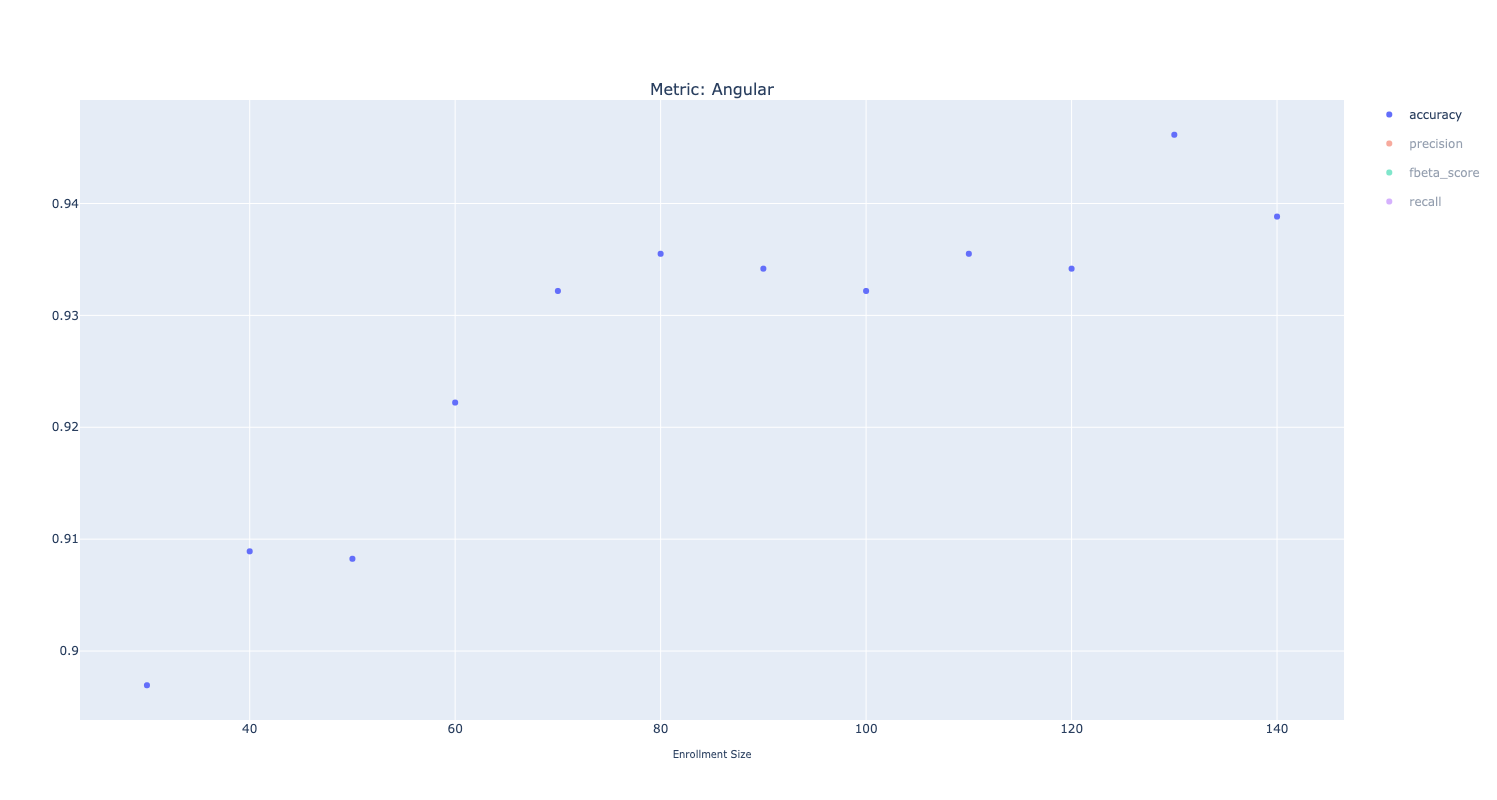

In [145]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


fig = make_subplots(
        rows=1,
        cols=1,
        shared_yaxes=True,
        vertical_spacing=0.01,
        horizontal_spacing=0.01,
        #row_heights=[0.5, 0.5],
        subplot_titles=("Metric: Angular", "Metric: Euclidean")
    )

plt_df1=metric_agg.copy()



fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["accuracy"],mode="markers+text",name="accuracy",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["precision"],mode="markers+text",name='precision',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["fbeta_score"],mode="markers+text",name='fbeta_score',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1.enrollment_batch_size, y=plt_df1["recall"],mode="markers+text",name='recall',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )


# fig.layout.annotations[1].update(text="Metric=Angular")
fig.update_xaxes(title_text="Enrollment Size", row=1, col=1, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)

fig.update_layout(
        height=800,
        width=1400,
        # xaxis_rangeslider_visible=False,
        xaxis_rangebreaks=[dict(values=[x for x in range(30,150,10)])]
    )

fig.show()

In [34]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 97.403


In [ ]:
# BATCH_SIZE = 100
# ln = len(enrollment_loader.dataset.imgs)

# results = []

# for i in tqdm(range(0,ln,BATCH_SIZE)):
#         img_batch= preprocess_images[i:i+BATCH_SIZE]
#         batch_tensor= [x[0] for x in img_batch]
#         image_input = torch.tensor(np.stack(batch_tensor)).to(device)
#         with torch.no_grad():
#             image_features = model.encode_image(image_input)
#             logits_per_image, logits_per_text = model(image_input, text)
#             # The softmax function takes the original confidence and applys a transform to make all the confidence add up to one
#             probs = logits_per_image.softmax(dim=-1).cpu().numpy()
#             results.append(probs)
            

# res = np.concatenate(results,axis=0)
# choices = np.argmax(res,axis=1)
# pred_label= [item_dict[i] for i in choices]
# true_label= [item_dict[x[1]] for x in preprocess_images]

# import sklearn
# from sklearn import metrics

# acc= metrics.accuracy_score(np.array(true_label),np.array(pred_label))
# report=sklearn.metrics.classification_report(np.array(true_label),np.array(pred_label))

# correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
# prec, rec,fscore,supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='macro')
# w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='weighted')
# report_dict=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),output_dict=True)

# print(acc)
# print(report)

In [99]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.92      0.96      0.94       111
           2       0.99      0.99      0.99       142
           3       0.94      1.00      0.97        46
           4       0.96      0.96      0.96       120
           5       1.00      1.00      1.00       125
           6       0.99      0.98      0.98        99
           7       0.97      0.94      0.96       119
           8       0.95      0.99      0.97       103
           9       0.99      0.99      0.99       114
          10       0.99      0.99      0.99        92
          11       0.99      0.97      0.98       115
          12       0.98      0.97      0.98       114
          13       0.97      0.95      0.96       109
          14       0.98      1.00      0.99        51

    accuracy                           0.98      1504
   macro avg       0.98      0.98      0.98      1504
weighted avg       0.98   

## Indexer based testing

In [5]:
def predict(model,classifier, test_loader,opt,pred_save_path,pred_filename,metrics_file_name):
    """
        Make predictions and save them in a pickle file.
        Print Classification metrics
        
        Arguments:
            model: Trained encoder model 
            classifier: Trained MLP
            valdata: Data to make predictions on
            test_loader: Data Loader created on valdata
            fname: Name of file to in which predictions will be saved
            
        Returns:
            List with predictions on valdata
    """     
    model.eval()
    classifier.eval()
    with torch.no_grad():
        pred1=[]
        print("Start Predictions")
        # Iterate over data.
        for idx, (images, labels) in enumerate(test_loader):
                images = images.float().cuda()
                output = classifier(model.encoder(images))
                _,preds=torch.max(output, 1)
                pred1.extend(preds.cpu().numpy())
                
    p=np.array(pred1)

    import pickle
    print('Prediction file saved here: ', os.path.join(pred_save_path,pred_filename))
    with open(os.path.join(pred_save_path,pred_filename), 'wb') as handle:
        pickle.dump(p, handle, protocol=pickle.HIGHEST_PROTOCOL)
    top_1_df = pd.DataFrame(columns=['true_label', 'predicted_label'])
    top_1_df['true_label']=np.array(test_loader.dataset.targets)
    top_1_df['predicted_label']= pred1
    top_1_df['true_label_gtin']=top_1_df['true_label'].apply(lambda x:val_rev_item_dict[x])
    top_1_df['predicted_label_gtin']=top_1_df['predicted_label'].apply(lambda x:train_rev_item_dict[x])
    # print(sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    print(top_1_df.head(10))
    print("")
    # metrics={"accuracy": sklearn.metrics.accuracy_score(np.array(test_loader.dataset.targets), pred1),
    #             "classification_report": sklearn.metrics.classification_report(np.array(test_loader.dataset.targets),pred1)
    #         }
    metrics={"accuracy": sklearn.metrics.accuracy_score(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])),
                "classification_report": sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin']))
            }
    

    print('Metrics file saved here: ', os.path.join(pred_save_path,metrics_file_name))
    with open(os.path.join(pred_save_path,metrics_file_name), 'w') as handle:
        json.dump(metrics,handle)
    print("Accuracy is",sklearn.metrics.accuracy_score(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    print(sklearn.metrics.classification_report(np.array(top_1_df['true_label_gtin']),np.array(top_1_df['predicted_label_gtin'])))
    return pred1

In [118]:
import os
import itertools
import numpy as np
import pickle
import sklearn
from sklearn import metrics
from annoy import AnnoyIndex
import pandas as pd
import faiss
import argparse
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def top1(metric_folder,train_X_df,test_X_df,annoy_metrics, train_rev_item_dict,val_rev_item_dict,n_trees=10,k_nearest_neighbor=1):
    """
                Calculate classification metrics using image similarity
                Arguments:
                    train_X_df: pd.Dataframe with train embeddings and labels
                    test_X_df: pd.Dataframe with test embeddings and labels
                    annoy_metrics: List of annoy similarity scores to be calculated
                    n_trees: Parameter for annoy similarity
                Returns:
                   Dictionary with all metrics
                   Saves dictionary as json
    """
    indexer_pth=os.path.join(metric_folder,'indexers')
    print(indexer_pth)
    if not os.path.exists(indexer_pth):
        os.mkdir(indexer_pth)


    metric_dict={}
    metric_dict['test_image_cnt']=test_X_df.shape[0]
    print('Total Test images= ', test_X_df.shape[0])
    print("")


    if not annoy_metrics:
        return
    for m in annoy_metrics:
        print('Metric =%s' % m)
        f = len(train_X_df['embedding'][0])
        t = AnnoyIndex(f, m)  # Length of item vector that will be indexed

        for i, vec in enumerate(train_X_df['embedding']):
            t.add_item(i, vec)

        t.build(n_trees, n_jobs=-1)  # 10 trees
        t.save(os.path.join(indexer_pth,str(m) + '.ann'))

        u = AnnoyIndex(f, m)  # Length of item vector that will be indexed
        u.load(os.path.join(indexer_pth,str(m) + '.ann'))  # super fast, will just mmap the file
        top_1 = pd.DataFrame(columns=['true_label', 'predicted_label'])
        for i in range(int(test_X_df.shape[0])):
            # print(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], k_nearest_neighbor))
            # print(int(train_X_df.iloc[int(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], 1)[0]), 1]))
            # pred_label = int(train_X_df.iloc[int(u.get_nns_by_vector(test_X_df.loc[i, 'embedding'], 1)[0]), 1])
            query= test_X_df.loc[i, 'embedding']
            pred_labels_idx= u.get_nns_by_vector(query, k_nearest_neighbor)
            pred_labels= [train_X_df.loc[x, "label"] for x in pred_labels_idx]
            pred_label= pd.Series(pred_labels).value_counts().index[0]
            # pred_label = np.bincount(pred_labels).argmax()
            # neighbors_df=pd.DataFrame({"neighbor_indices": pred_labels_idx,"neighbor_labels":pred_labels })
            # neighbors_df['freq'] = neighbors_df.groupby('neighbor_labels')['neighbor_labels'].transform('count')
            # neighbors_df.sort_values(by='freq',ascending=False,inplace=True)
            # print(neighbors_df)
            
            
            
            true_label = int(test_X_df.iloc[i, 1])
            # print(f"Indexes: {pred_labels_idx}. Pred labels are: {pred_labels} majority voted label is {pred_label}.True label: {true_label} ")
            
            top_1 = top_1.append(pd.Series([true_label, pred_label], index=top_1.columns), ignore_index=True)

        top_1['true_label'] = top_1['true_label'].astype(int)
        top_1['predicted_label'] = top_1['predicted_label'].astype(int)

        top_1['true_label_gtin']=top_1['true_label'].apply(lambda x:val_rev_item_dict[x])
        top_1['predicted_label_gtin']=top_1['predicted_label'].apply(lambda x:train_rev_item_dict[x])

        acc= metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
        correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
        prec, rec,fscore,supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='macro')
        w_prec, w_rec,w_fscore,w_supp=precision_recall_fscore_support(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']), average='weighted')
        report=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
        report_dict=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),output_dict=True)


        # acc= metrics.accuracy_score(np.array(top_1['true_label']), np.array(top_1['predicted_label']))
        # correct=metrics.accuracy_score(np.array(top_1['true_label']), np.array(top_1['predicted_label']),normalize=False)
        # report=sklearn.metrics.classification_report(np.array(top_1['true_label']),np.array(top_1['predicted_label']))

        metric_dict[f'annoy_{m}_{str(k_nearest_neighbor)}nn']={'accuracy':acc,'precision': prec,"recall": rec,"fbeta": fscore,"support": supp,\
                                 'weighted_precision': w_prec,"weighted_recall": w_rec,"weighted_fbeta": w_fscore,"weighted_support": w_supp,\
                                 'classification_report':report,'classification_report_dict':report}

    ##### FAISS EMBEDS ####
    # print("Metric =faiss_l2")
    # embeds = []
    # for a in train_X_df['embedding']:
    #     embeds.append(a)
    # test_embeds = []
    # for a in test_X_df['embedding']:
    #     test_embeds.append(a)
    # index = faiss.IndexFlatL2(2048)  # build the index
    # index.add(np.array(embeds))

    # top_1 = pd.DataFrame(columns=['true_label', 'predicted_label'])
    # for i in range(test_X_df.shape[0]):
    #     pred_label = int(train_X_df.iloc[index.search(np.array([test_embeds[i]]), 1)[1][0][0]].label)
    #     true_label = int(test_X_df.iloc[i, 1])
    #     top_1 = top_1.append(pd.Series([true_label, pred_label], index=top_1.columns), ignore_index=True)

    # top_1['true_label'] = top_1['true_label'].astype(int)
    # top_1['predicted_label'] = top_1['predicted_label'].astype(int)
    
    # top_1['true_label_gtin']=top_1['true_label'].apply(lambda x:val_rev_item_dict[x])
    # top_1['predicted_label_gtin']=top_1['predicted_label'].apply(lambda x:train_rev_item_dict[x])
    # print(sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin'])))
    
    # acc= metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
    # correct=metrics.accuracy_score(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']),normalize=False)
    # report=sklearn.metrics.classification_report(np.array(top_1['true_label_gtin']),np.array(top_1['predicted_label_gtin']))
    
    # print("Accuracy is", acc)
    # print("Correct Label Count: ",correct)
    
    # metric_dict['faiss_l2'] = {'accuracy': acc, 'classification_report': report}
    # print("")

    return metric_dict

def saveMetric(metric_dict, dir,dataset_name="train_enrollment",n_trees=10,eset=None):
    """
                    Save metrics in json format
                    Arguments:
                        metric_dict: dict object to be saved
    """
    if eset:
        with open(os.path.join(dir,f'{dataset_name}_{eset}_nt{n_trees}_metrics.json'), 'w') as handle:
            json.dump(metric_dict,handle)
    else:
        with open(os.path.join(dir,f'{dataset_name}_nt{n_trees}_metrics.json'), 'w') as handle:
            json.dump(metric_dict,handle)
        
    print('JSON saved')


In [181]:
# gtin_enrollment_label= enrollment_labels.copy()
# gtin_test_label= test_labels.copy()

# for idx,val in enumerate(enrollment_labels):
#     gtin_enrollment_label[idx]=enrollment_label_dict[val]

# for idx,val in enumerate(test_labels):
#     gtin_test_label[idx]=test_label_dict[val]

edf = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(enrollment_features, enrollment_labels):
    edf=edf.append({'embedding': i, "label": j},ignore_index=True)
    
    
test_X_df = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(test_features, test_labels):
    test_X_df=test_X_df.append({'embedding': i, "label": j},ignore_index=True)
    


In [184]:
annoy_metrics=['angular','euclidean']
n_trees=10
metric_folder= "/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics"
dataset_name= 'train_enrollment'

k_effect=pd.DataFrame(columns=["n_trees","test_image_cnt", "k","Annoy_angular_acc","Annoy_euclidean_acc", "Annoy_angular_prec", "Annoy_euclidean_prec","Annoy_angular_rec","Annoy_euclidean_rec",\
                              "Annoy_angular_fbeta", "Annoy_euclidean_fbeta"])
for nt in range(5,50,5):
    for k in range(3,4):
        print(f"n_trees = {nt}")
        print(f"Testing k = {k}")
        row={}
        metric_dict=top1(metric_folder,edf, test_X_df, annoy_metrics,enrollment_label_dict,test_label_dict, n_trees=nt, k_nearest_neighbor=k)
        row["n_trees"]= nt
        row["test_image_cnt"]= metric_dict["test_image_cnt"]
        row["k"]= k
        row["Annoy_angular_acc"]= metric_dict[f"annoy_angular_{k}nn"]["accuracy"]
        row["Annoy_euclidean_acc"]= metric_dict[f"annoy_euclidean_{k}nn"]["accuracy"]
        row["Annoy_angular_prec"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_precision"]
        row["Annoy_euclidean_prec"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_precision"]
        row["Annoy_angular_rec"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_recall"]
        row["Annoy_euclidean_rec"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_recall"]
        row["Annoy_angular_fbeta"]= metric_dict[f"annoy_angular_{k}nn"]["weighted_fbeta"]
        row["Annoy_euclidean_fbeta"]= metric_dict[f"annoy_euclidean_{k}nn"]["weighted_fbeta"]
        k_effect= k_effect.append(row, ignore_index=True)

k_effect.to_csv("k_effect_80gtin.csv")
        # row["distance_metric"]= metric_dict.keys()[1].split("_")[1]
        # saveMetric(metric_dict,metric_folder,dataset_name,nt)

n_trees = 5
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 10
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 15
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 20
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 25
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 30
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test images=  10661

Metric =angular
Metric =euclidean
n_trees = 35
Testing k = 3
/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics/indexers
Total Test i

In [185]:
# k_effect_3= k_effect[k_effect["k"]==3]
# k_effect[k_effect["k"]==1]
k_effect.sort_values(by = ["Annoy_angular_acc"],ascending=False)

,n_trees,test_image_cnt,k,Annoy_angular_acc,Annoy_euclidean_acc,Annoy_angular_prec,Annoy_euclidean_prec,Annoy_angular_rec,Annoy_euclidean_rec,Annoy_angular_fbeta,Annoy_euclidean_fbeta
7,40.0,10661.0,3.0,0.827690,0.836225,0.840537,0.846983,0.827690,0.836225,0.829958,0.837686
6,35.0,10661.0,3.0,0.827221,0.834725,0.840311,0.845577,0.827221,0.834725,0.829539,0.836180
8,45.0,10661.0,3.0,0.827127,0.836694,0.840151,0.847225,0.827127,0.836694,0.829523,0.838057
5,30.0,10661.0,3.0,0.826939,0.834725,0.839306,0.845126,0.826939,0.834725,0.828934,0.836116
4,25.0,10661.0,3.0,0.825251,0.830504,0.837015,0.841232,0.825251,0.830504,0.827070,0.832001
3,20.0,10661.0,3.0,0.823469,0.829941,0.835269,0.840337,0.823469,0.829941,0.825290,0.831331
2,15.0,10661.0,3.0,0.822156,0.826939,0.834076,0.837580,0.822156,0.826939,0.824154,0.828370
1,10.0,10661.0,3.0,0.818966,0.823844,0.830979,0.834104,0.818966,0.823844,0.820902,0.825108
0,5.0,10661.0,3.0,0.808648,0.816059,0.820861,0.827492,0.808648,0.816059,0.810549,0.817416


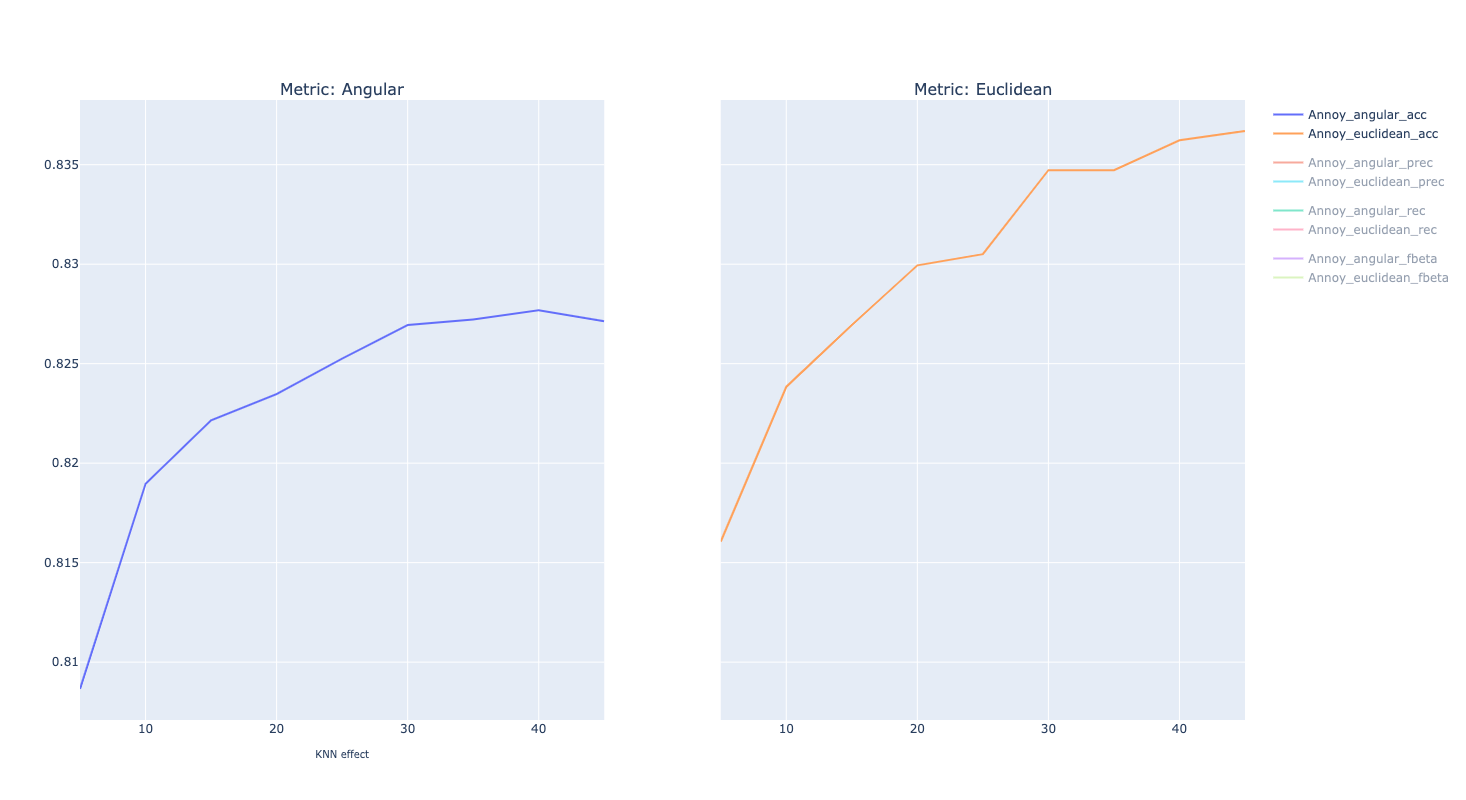

In [189]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


fig = make_subplots(
        rows=1,
        cols=2,
        shared_yaxes=True,
        vertical_spacing=0.01,
        horizontal_spacing=0.1,
        # row_heights=[0.5, 0.5],
        subplot_titles=("Metric: Angular", "Metric: Euclidean")
    )

plt_df1=k_effect.copy()


mode="lines"# "markers+text"
x_col= "n_trees"
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_acc"],mode=mode,name="Annoy_angular_acc",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_prec"],mode=mode,name='Annoy_angular_prec',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_rec"],mode=mode,name='Annoy_angular_rec',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_angular_fbeta"],mode=mode,name='Annoy_angular_fbeta',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=1,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_acc"],mode=mode,name="Annoy_euclidean_acc",legendgroup ='accuracy'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )
fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_prec"],mode=mode,name='Annoy_euclidean_prec',legendgroup ='precision'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_rec"],mode=mode,name='Annoy_euclidean_rec',legendgroup ='recall'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

fig.add_trace(
        go.Scatter(
            x=plt_df1[x_col], y=plt_df1["Annoy_euclidean_fbeta"],mode=mode,name='Annoy_euclidean_fbeta',legendgroup ='fbeta_score'# , line=dict(color="blue", width=2)
        ),
        row=1,
        col=2,
    )

# fig.layout.annotations[1].update(text="Metric=Angular")
fig.update_xaxes(title_text="KNN effect", row=1, col=1, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)
# fig.update_yaxes(title_text="Metrics in %", row=1, col=2, title_font_size=10)

fig.update_layout(
        height=800,
        width=1400,
        # xaxis_rangeslider_visible=False,
        xaxis_rangebreaks=[dict(values=[x for x in range(30,150,10)])]
    )

fig.show()

## Scann

In [1]:
import numpy as np
import h5py
import os
import requests
import tempfile
import time

import scann

In [ ]:
# enrollment_features, enrollment_labels = get_features(enrollment_preprocess, 100)
# test_features, test_labels = get_features(test_preprocess, 100)

edf = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(enrollment_features, enrollment_labels):
    edf=edf.append({'embedding': i, "label": j},ignore_index=True)
    
    
test_X_df = pd.DataFrame(columns=['embedding', 'label'])
for i,j in zip(test_features, test_labels):
    test_X_df=test_X_df.append({'embedding': i, "label": j},ignore_index=True)
    

metric_folder= "/home/jupyter/dvc-manual/gtin_60/models/CLIP/metrics"
dataset_name= 'train_enrollment'

for nt in range(5,101,5):
    metric_dict=top1(metric_folder,edf, test_X_df, annoy_metrics,enrollment_label_dict,test_label_dict, n_trees=nt)
    saveMetric(metric_dict,metric_folder,dataset_name,nt)

In [4]:
normalized_dataset = enrollment_features / np.linalg.norm(enrollment_features, axis=1)[:, np.newaxis]
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
searcher = scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product").tree(
    num_leaves=2000, num_leaves_to_search=100).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2022-02-14 20:47:18.478576: I scann/partitioning/partitioner_factory_base.cc:71] Size of sampled dataset for training partition: 5763
2022-02-14 20:47:21.220921: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:102] PartitionerFactory ran in 2.742211628s.


In [ ]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

In [ ]:
# this will search the top 100 of the 2000 leaves, and compute
# the exact dot products of the top 100 candidates from asymmetric
# hashing to get the final top 10 candidates.
start = time.time()
neighbors, distances = searcher.search_batched(queries)
end = time.time()

# we are given top 100 neighbors in the ground truth, so select top 10
print("Recall:", compute_recall(neighbors, glove_h5py['neighbors'][:, :10]))
print("Time:", end - start)

## Triton Deployment

In [54]:
import os
import sys
from datetime import datetime
import torch

class Saver:
    def __init__(self):
        self.date = str(datetime.now().date())

    def save_model(self,model, opt, save_file):
        print('==> Saving...')
        state = {
            'opt': opt,
            'model': model.state_dict(),
            # 'optimizer': optimizer.state_dict(),
            # 'epoch': epoch,
        }
        torch.save(state, save_file)
        del state


    def model_saver(self, model,  opt, save_file):
        save_file_path=os.path.join(save_file)#'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))    
        self.save_model(model, opt, save_file_path)
        return save_file_path    

opt={"model": "CLIP",
     "save_folder": "/home/jupyter/dvc-manual/gtin_60/models/CLIP",
    }

save_file = os.path.join(opt["save_folder"], f'clip_encoder_{enrollment_size}_{set_number}.pth')
svr= Saver()
svr.model_saver(model, opt, save_file)

==> Saving...


'/home/jupyter/dvc-manual/gtin_60/models/CLIP/clip_encoder_90_1.pth'

In [85]:
enrollment_features.dtype

dtype('float16')

In [84]:
## Save TorchScript model

def saveTorchScriptModel(opt,model):
    model_name="CLIP"
    folder_save= "/home/jupyter/dvc-manual/gtin_60/models/CLIP"
    if not os.path.isdir(folder_save):
        os.makedirs(folder_save, mode=0o777)
    
    folder_save_model= os.path.join(folder_save,"1")
    if not os.path.isdir(folder_save_model):
        os.makedirs(folder_save_model, mode=0o777)

    img_size=(224,224)
    img=torch.randn(1, 3, img_size[0],img_size[1]).type(model.dtype).cuda()

    traced_model = torch.jit.trace(model.visual,img)
    traced_model.save(os.path.join(folder_save_model,'model.pt'))

   
    x = 'name: "{}"'.format(model_name)
    config=x +' \nplatform: "pytorch_libtorch" \ninput [ \n{\nname: "input__0"\ndata_type: TYPE_FP16\ndims: [-1, 3,224,224]\n} \n]\noutput {\nname: "output__0"\ndata_type: TYPE_FP16\ndims: [-1, 512]\n}'

    pbtxt_file = open(os.path.join(folder_save,'config.pbtxt'), "w")
    pbtxt_file.write(config)
    pbtxt_file.close()





saveTorchScriptModel(opt,model)
    

In [86]:
loaded = torch.jit.load('/home/jupyter/dvc-manual/gtin_60/models/CLIP/1/model.pt')

In [93]:
model.dtype

torch.float16

In [190]:
ground_truth = torch.arange(100,dtype=torch.long,device=device)

In [191]:
ground_truth

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99], device='cuda:0')

In [9]:
import requests
url = f"http://catalog-es-service.prod.cdqarth.prod.walmart.com/es-service/products/search?tenantId=0&filter=product_attributes.gtin.values.value==00009800800254"
r = requests.get(url)
r.json()

ConnectionError: HTTPConnectionPool(host='catalog-es-service.prod.cdqarth.prod.walmart.com', port=80): Max retries exceeded with url: /es-service/products/search?tenantId=0&filter=product_attributes.gtin.values.value==00009800800254 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f8c354ac450>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [10]:
import os
path="dvc-manual/gtin_60/data/prep/80gtin_allsubfolders/splitfolders/train"
os.listdir(os.path.join("/home/jupyter",path))

['00044000069216',
 '00078742351919',
 '00019100110007',
 '00078742370064',
 '00048500202746',
 '00010900003308',
 '00016000123151',
 '00012000809941',
 '00016000468139',
 '00038000138416',
 '00781138710183',
 '00044000033279',
 '00078742370378',
 '00034000003303',
 '00078742433042',
 '00019200771825',
 '00048001213487',
 '00078742237336',
 '00049000012781',
 '00044000033255',
 '00019200793292',
 '00016000124790',
 '00024100440702',
 '00078742012285',
 '00078742351865',
 '00049000067217',
 '00034500151368',
 '00014100085478',
 '00044600015941',
 '00049000025422',
 '00044000034207',
 '00078742372211',
 '00028400589895',
 '00078742352008',
 '00030100112334',
 '00078742371177',
 '00013000006057',
 '00078742223759',
 '00044700024102',
 '00043000071519',
 '00025500005188',
 '00051500062005',
 '00078742374192',
 '00041167053508',
 '00012000001314',
 '00703820010944',
 '00044000046545',
 '00078742097282',
 '00078742351872',
 '00017000047287',
 '00038000138430',
 '00072250037068',
 '0007874237